In [61]:
import common_datasets.binary_classification as binclas
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

from mlscorecheck.auc import simplify_roc

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import wilcoxon

In [62]:
def generate_random_classifier(random_state):
    mode = random_state.randint(4)
    if mode == 0:
        classifier = RandomForestClassifier
        params = {'max_depth': random_state.randint(2, 10),
                  'random_state': 5}
    if mode == 1:
        classifier = DecisionTreeClassifier
        params = {'max_depth': random_state.randint(2, 10),
                  'random_state': 5}
    if mode == 2:
        classifier = SVC
        params = {'probability': True, 'C': random_state.rand()/2 + 0.001}
    if mode == 3:
        classifier = KNeighborsClassifier
        params = {'n_neighbors': random_state.randint(2, 10)}
    
    return (classifier, params)

In [63]:
datasets = binclas.get_filtered_data_loaders(n_col_bounds=(0, 50), n_bounds=(0, 2000), n_minority_bounds=(20, 1000), n_from_phenotypes=1, imbalance_ratio_bounds=(0.2, 20.0))

In [64]:
len(datasets)

28

In [65]:
names = [dataset()['name'] for dataset in datasets if not dataset()['name'].startswith('led')]

In [66]:
from common_datasets.binary_classification import summary_pdf

In [67]:
tmp = summary_pdf[summary_pdf['name'].isin(names)].reset_index(drop=True)
tmp = tmp[['name', 'n_col', 'n', 'n_minority', 'imbalance_ratio', 'citation_key']]
tmp['name_key'] = tmp.apply(lambda row: f'{row["name"]} \\cite{{{row["citation_key"]}}}', axis=1)
tmp = tmp[['name_key', 'n', 'n_col', 'n_minority', 'imbalance_ratio']]
tmp.columns = ['name', 'size', 'attr.', 'p', 'imb. ratio']
tmp['n'] = tmp['size'] - tmp['p']
tmp = tmp[['name', 'size', 'attr.', 'p', 'n', 'imb. ratio']]

In [68]:
tmp.index = [idx for idx in range(1, 28)]
print(tmp.to_latex(float_format="%.2f").replace('_', ' '))

\begin{tabular}{llrrrrr}
\toprule
 & name & size & attr. & p & n & imb. ratio \\
\midrule
1 & abalone9 18 \cite{keel} & 731 & 9 & 42 & 689 & 16.40 \\
2 & appendicitis \cite{keel} & 106 & 7 & 21 & 85 & 4.05 \\
3 & australian \cite{keel} & 690 & 16 & 307 & 383 & 1.25 \\
4 & bupa \cite{keel} & 345 & 6 & 145 & 200 & 1.38 \\
5 & CM1 \cite{krnn} & 498 & 21 & 49 & 449 & 9.16 \\
6 & crx \cite{keel} & 653 & 37 & 296 & 357 & 1.21 \\
7 & dermatology-6 \cite{keel} & 358 & 34 & 20 & 338 & 16.90 \\
8 & ecoli1 \cite{keel} & 336 & 7 & 77 & 259 & 3.36 \\
9 & glass0 \cite{keel} & 214 & 9 & 70 & 144 & 2.06 \\
10 & haberman \cite{keel} & 306 & 3 & 81 & 225 & 2.78 \\
11 & hepatitis \cite{krnn} & 155 & 19 & 32 & 123 & 3.84 \\
12 & ionosphere \cite{keel} & 351 & 33 & 126 & 225 & 1.79 \\
13 & iris0 \cite{keel} & 150 & 4 & 50 & 100 & 2.00 \\
14 & mammographic \cite{keel} & 830 & 5 & 403 & 427 & 1.06 \\
15 & monk-2 \cite{keel} & 432 & 6 & 204 & 228 & 1.12 \\
16 & new thyroid1 \cite{keel} & 215 & 5 & 35 & 180 & 

In [113]:
def pava(array, sample_weight):
    output = array.copy()
    counts = np.repeat(1, output.shape[0])
    prev_pool = np.repeat(1, output.shape[0])
    sample_weight = sample_weight.copy()

    idx = 0
    while idx + counts[idx] < output.shape[0]:
        next_pool_idx = idx + counts[idx]
        if output[idx] <= output[next_pool_idx]:
            idx = next_pool_idx
            continue
        else:
            total_weight = sample_weight[idx] + sample_weight[next_pool_idx]
            term_0 = sample_weight[idx] * output[idx]
            term_1 = sample_weight[next_pool_idx] * output[next_pool_idx]
            output[idx] = (term_0 + term_1) / total_weight

            next_next_pool_idx = next_pool_idx  +counts[next_pool_idx]
            if next_next_pool_idx < output.shape[0]:
                prev_pool[next_next_pool_idx] = counts[idx] + counts[next_pool_idx]
            
            sample_weight[idx] = sample_weight[idx] + sample_weight[next_pool_idx]

            counts[idx] = counts[idx] + counts[next_pool_idx]

            if prev_pool[idx] <= idx:
                idx -= prev_pool[idx]
    
    result = array.copy()

    idx = 0
    while idx < array.shape[0]:
        next_pool_idx = idx + counts[idx]
        result[idx:next_pool_idx] = output[idx]
        idx = next_pool_idx
    
    return result

In [107]:
def linearize_roc_curve(fprs, tprs):
    fprs_new = []
    tprs_new = []
    
    if fprs[1] == 0:
        fprs_new.append(fprs[1])
        tprs_new.append(tprs[1])
    else:
        fprs_new.append(fprs[0])
        tprs_new.append(tprs[0])
    
    i = 1
    while i <= len(fprs) - 2:
        if fprs[i] != fprs[i+1]:
            fprs_new.append(fprs[i])
            tprs_new.append(tprs[i])
        else:
            fpr_diff_left = (fprs[i] - fprs_new[-1]) * (tprs[i] - tprs_new[-1])
            fpr_diff_right = (fprs[i+2] - fprs[i-1]) * (tprs[i+2] - tprs[i-1])

            fpr_diff_left, fpr_diff_right = fpr_diff_left / (fpr_diff_left + fpr_diff_right), fpr_diff_right / (fpr_diff_left + fpr_diff_right)

            fprs_new.append(fprs[i])
            tprs_new.append(fpr_diff_left * tprs[i+1] + fpr_diff_right * tprs[i])
            i += 1
        i += 1
    fprs_new.append(fprs[i])
    tprs_new.append(tprs[i])

    return np.array(fprs_new), np.array(tprs_new)
        

In [108]:
fprs = np.array([0, 0.2, 0.4, 0.4, 0.5, 0.7, 0.9, 0.9, 1.0])
tprs = np.array([0, 0.3, 0.5, 0.6, 0.8, 0.8, 0.85, 0.94, 1.0])

In [109]:
from mlscorecheck.auc import integrate_roc_curve

In [110]:
integrate_roc_curve(fprs, tprs)

0.602

In [111]:
fprs_new, tprs_new = linearize_roc_curve(fprs, tprs)

In [112]:
integrate_roc_curve(fprs_new, tprs_new)

0.5975864661654136

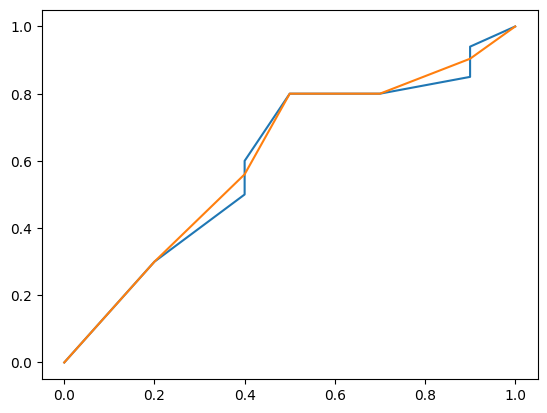

In [100]:
plt.plot(fprs, tprs)
plt.plot(fprs_new, tprs_new)

In [69]:
def acc_sens_spec_at_th(y_test, y_pred, th):
    tp = np.sum((y_pred >= th) & (y_test == 1))
    tn = np.sum((y_pred < th) & (y_test == 0))
    p = np.sum(y_test)
    n = len(y_test) - np.sum(y_test)

    return (tp + tn)/(p + n), tp/p, tn/n

In [70]:
def calculate_scores(y_test, y_pred, y_train, random_state, label=''):
    threshold = np.sum(y_train)/len(y_train)

    acc, sens, spec = acc_sens_spec_at_th(y_test, y_pred, threshold)

    best_ths = []
    best_acc = 0
    for th in np.hstack([np.unique(y_pred), np.array([-np.inf, np.inf])]):
        acc_tmp, _, _ = acc_sens_spec_at_th(y_test, y_pred, th)

        if acc_tmp > best_acc:
            best_acc = acc_tmp
            best_ths = [th]
        elif acc_tmp == best_acc:
            best_ths.append(th)

    best_th = random_state.choice(best_ths)

    best_acc, best_sens, best_spec = acc_sens_spec_at_th(y_test, y_pred, best_th)

    return {
        f'acc{label}': acc,
        f'sens{label}': sens,
        f'spec{label}': spec,
        f'threshold{label}': threshold,
        f'best_acc{label}': best_acc,
        f'best_sens{label}': best_sens,
        f'best_spec{label}': best_spec,
        f'best_threshold{label}': best_th
    }

In [71]:
def best_aggregated_scores(y_trues, y_preds, random_state, label=''):
    thresholds = np.unique(np.hstack(y_trues))

    best_ths = []
    best_acc = 0
    for th in thresholds.tolist() + [np.inf, -np.inf]:
        acc_tmp = np.mean([acc_sens_spec_at_th(y_true, y_pred, th)[0] for y_true, y_pred in zip(y_trues, y_preds)])

        if acc_tmp > best_acc:
            best_acc = acc_tmp
            best_ths = [th]
        elif acc_tmp == best_acc:
            best_ths.append(th)

    best_th = random_state.choice(best_ths)

    scores = [acc_sens_spec_at_th(y_true, y_pred, best_th) for y_true, y_pred in zip(y_trues, y_preds)]

    best_acc = np.mean([item[0] for item in scores])
    best_sens = np.mean([item[1] for item in scores])
    best_spec = np.mean([item[2] for item in scores])

    return {
        f'best_acc{label}': best_acc,
        f'best_sens{label}': best_sens,
        f'best_spec{label}': best_spec
    }

In [72]:
def process_results(fold_results, random_state):
    results = {}

    results = results | best_aggregated_scores(
        [record['y_test'] for record in fold_results],
        [record['y_pred'] for record in fold_results],
        random_state
    )

    results = results | best_aggregated_scores(
        [record['y_train'] for record in fold_results],
        [record['y_pred_train'] for record in fold_results],
        random_state,
        label='_train'
    )

    results = results | {
        'acc': np.mean([record['acc'] for record in fold_results]),
        'sens': np.mean([record['sens'] for record in fold_results]),
        'spec': np.mean([record['spec'] for record in fold_results]),
        'auc': np.mean([record['auc'] for record in fold_results]),
        'acc_train': np.mean([record['acc_train'] for record in fold_results]),
        'sens_train': np.mean([record['sens_train'] for record in fold_results]),
        'spec_train': np.mean([record['spec_train'] for record in fold_results]),
        'auc_train': np.mean([record['auc_train'] for record in fold_results])
    }

    roc = []
    roc_train = []

    for record in fold_results:
        fprs, tprs, thresholds = simplify_roc(*roc_curve(record['y_test'], record['y_pred']))
        roc.append((fprs.tolist(), tprs.tolist(), thresholds.tolist()))
        fprs_train, tprs_train, thresholds_train = simplify_roc(*roc_curve(record['y_train'], record['y_pred_train']))
        roc_train.append((fprs_train.tolist(), tprs_train.tolist(), thresholds_train.tolist()))


    n_nodes = np.mean([len(curve[0]) for curve in roc])
    n_nodes_train = np.mean([len(curve[0]) for curve in roc_train])

    results = results | {
        'n_nodes': n_nodes, 
        'n_nodes_train': n_nodes_train,
        'roc': str(roc),
        'roc_train': str(roc_train)
    }

    return results


In [73]:
N_SAMPLES = 10

results = []
random_state = np.random.RandomState(5)
dropped = 0

while len(results) < N_SAMPLES:
    result = {}

    loader = random_state.choice(datasets)
    dataset = loader()

    X = dataset['data']
    y = dataset['target']
    name = dataset['name']

    if random_state.randint(2) == 0:
        y = 1 - y

    p_total = np.sum(y)
    n_total = len(y) - p_total

    k = random_state.randint(2, 11)
    while k > p_total:
        k = random_state.randint(2, 11)

    result = result | {'p': p_total, 'n': n_total, 'k': k, 'dataset': name}
    
    fold_results = []

    classifier = generate_random_classifier(random_state)

    result = result | {'classifier': classifier[0].__name__, 'classifier_params': str(classifier[1])}

    classifier_obj = classifier[0](**classifier[1])
    
    for train, test in StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state).split(X, y):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]

        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

        classifier_obj.fit(X_train, y_train)

        y_pred = classifier_obj.predict_proba(X_test)[:, 1]
        y_pred_train = classifier_obj.predict_proba(X_train)[:, 1]

        scores = calculate_scores(y_test, y_pred, y_train, random_state)
        scores_train = calculate_scores(y_train, y_pred_train, y_train, random_state, '_train')

        auc = roc_auc_score(y_test, y_pred)
        auc_train = roc_auc_score(y_train, y_pred_train)

        fold_results.append(scores | scores_train | {'auc': auc, 'auc_train': auc_train, 
                'y_pred': y_pred, 'y_test': y_test, 
                'y_pred_train': y_pred_train, 'y_train': y_train})

    if np.mean([record['auc'] for record in fold_results]) < 0.5:
        dropped += 1
        continue

    result = result | process_results(fold_results, random_state)
    
    results.append(result)


In [74]:
dropped

0

In [75]:
data = pd.DataFrame.from_dict(results)

In [76]:
data.head()

,p,n,k,dataset,classifier,classifier_params,best_acc,best_sens,best_spec,best_acc_train,...,spec,auc,acc_train,sens_train,spec_train,auc_train,n_nodes,n_nodes_train,roc,roc_train
0,200,145,8,bupa,SVC,"{'probability': True, 'C': 0.4603054539689608}",0.579744,1.000000,0.000000,0.579711,...,0.649488,0.731784,0.752794,0.774286,0.723160,0.824103,19.75,100.250,"[([0.0, 0.0, 0.10526315789473684, 0.1052631578...","[([0.0, 0.0, 0.007936507936507936, 0.007936507..."
1,145,200,2,bupa,RandomForestClassifier,"{'max_depth': 4, 'random_state': 5}",0.579715,0.000000,1.000000,0.579715,...,0.720000,0.733862,0.924620,0.937785,0.915000,0.977109,72.50,22.000,"[([0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0....","[([0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.05, 0.0..."
2,126,225,8,ionosphere,DecisionTreeClassifier,"{'max_depth': 5, 'random_state': 5}",0.871829,0.785937,0.919643,0.963370,...,0.919643,0.888328,0.967441,0.911589,0.998731,0.970760,4.25,5.125,"[([0.0, 0.0, 1.0], [0.0, 0.8666666666666667, 1...","[([0.0, 0.0, 0.07142857142857142, 0.9744897959..."
3,145,200,2,bupa,SVC,"{'probability': True, 'C': 0.08889747830955769}",0.579715,0.000000,1.000000,0.579715,...,0.615000,0.681413,0.756553,0.765696,0.750000,0.846906,78.50,53.500,"[([0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.05, 0.0...","[([0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.0..."
4,429,1055,8,yeast1,SVC,"{'probability': True, 'C': 0.2553153590001828}",0.710920,0.000000,1.000000,0.710917,...,0.839781,0.789363,0.776762,0.594738,0.850778,0.813447,61.00,385.125,"[([0.0, 0.0, 0.007575757575757576, 0.007575757...","[([0.0, 0.0, 0.0010834236186348862, 0.00108342..."


In [79]:
data.iloc[0]

p                                                                  200
n                                                                  145
k                                                                    8
dataset                                                           bupa
classifier                                                         SVC
classifier_params       {'probability': True, 'C': 0.4603054539689608}
best_acc                                                      0.579744
best_sens                                                          1.0
best_spec                                                          0.0
best_acc_train                                                0.579711
best_sens_train                                                    1.0
best_spec_train                                                    0.0
acc                                                           0.681224
sens                                                             0.705
spec  

In [114]:
row = data.iloc[0]

In [116]:
roc_curves = eval(row['roc'], {'inf': np.inf})

In [188]:
fprs0 = np.array(roc_curves[0][0])
tprs0 = np.array(roc_curves[0][1])
fprs1 = np.array(roc_curves[1][0])
tprs1 = np.array(roc_curves[1][1])
fprs2 = np.array(roc_curves[2][0])
tprs2 = np.array(roc_curves[2][1])

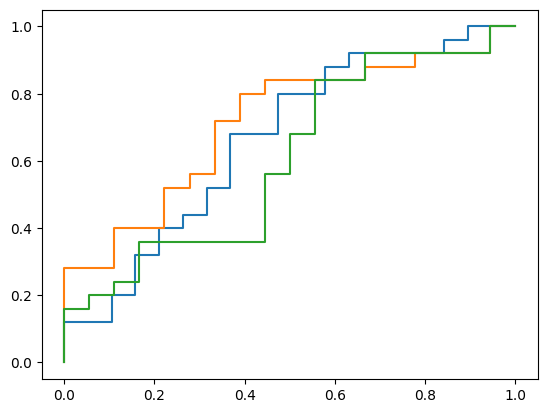

In [189]:
plt.plot(fprs0, tprs0)
plt.plot(fprs1, tprs1)
plt.plot(fprs2, tprs2)

In [190]:
integrate_roc_curve(fprs0, tprs0), integrate_roc_curve(fprs1, tprs1), integrate_roc_curve(fprs2, tprs2)

(0.6631578947368422, 0.7133333333333334, 0.6066666666666668)

In [192]:
np.mean([integrate_roc_curve(fprs0, tprs0), integrate_roc_curve(fprs1, tprs1), integrate_roc_curve(fprs2, tprs2)])

np.float64(0.6610526315789474)

In [139]:
def roc_value_at(fpr, fprs, tprs):
    values = []
    for idx in range(len(fprs)):
        if fprs[idx] == fpr:
            values.append(tprs[idx])
        elif idx < len(fprs) and fpr > fprs[idx] and fpr < fprs[idx+1]:
            diff_left = fpr - fprs[idx]
            diff_right = fprs[idx+1] - fpr

            diff_sum = diff_left + diff_right

            diff_left, diff_right = diff_left/diff_sum, diff_right/diff_sum

            values.append(tprs[idx] * diff_right + tprs[idx+1]*diff_left)
            break

    return np.array([values])

In [140]:
def avg_2_roc_curves_(fprs0, tprs0, fprs1, tprs1):
    fprs_new = []
    tprs_new = []
    for fpr, tpr in zip(fprs0, tprs0):
        tpr1s = roc_value_at(fpr, fprs1, tprs1)
        for tpr1 in tpr1s:
            fprs_new.append(fpr)
            tprs_new.append((tpr + tpr1)/2)
    
    return np.array(fprs_new), np.array(tprs_new)

In [179]:
def avg_n_roc_curves_(fprs0, tprs0, fprs, tprs):
    fprs_new = []
    tprs_new = []
    for fpr, tpr in zip(fprs0, tprs0):
        tpr_x = np.array([tpr, tpr])
        for jdx in range(len(fprs)):
            tpr_js = roc_value_at(fpr, fprs[jdx], tprs[jdx])
            tpr_x += tpr_js
        
        fprs_new.append(fpr)
        tprs_new.append(tpr_x[0]/(1 + len(fprs)))

        if tpr_x[0] != tpr_x[1]:
            fprs_new.append(fpr)
            tprs_new.append(tpr_x[1]/(1 + len(fprs)))
    
    return np.array(fprs_new), np.array(tprs_new)

In [184]:
def avg_n_roc_curves(fprs, tprs):
    fprs_new = []
    tprs_new = []

    for idx in range(len(fprs)):
        fprs_b = fprs[0:idx] + fprs[(idx+1):]
        tprs_b = tprs[0:idx] + tprs[(idx+1):]
        fprs_a, tprs_a = avg_n_roc_curves_(fprs[idx], tprs[idx], fprs_b, tprs_b)
        fprs_new.append(fprs_a)
        tprs_new.append(tprs_a)
    
    fprs5 = np.hstack(fprs_new)
    tprs5 = np.hstack(tprs_new)

    rates = np.vstack([fprs5, tprs5]).T.copy()

    sorting = np.argsort(rates[:, 0])
    rates = rates[sorting]
    sorting = np.argsort(rates[:, 1])
    rates = rates[sorting]
    rates = np.unique(rates, axis=0)

    fprs5 = rates[:, 0]
    tprs5 = rates[:, 1]

    fprs5, tprs5, _ = simplify_roc(fprs5, tprs5, np.repeat(0, len(fprs5)))

    return fprs5, tprs5

In [180]:
def avg_2_roc_curves(fprs0, tprs0, fprs1, tprs1):
    #fprs3, tprs3 = avg_2_roc_curves_(fprs1, tprs1, fprs0, tprs0)
    #fprs4, tprs4 = avg_2_roc_curves_(fprs0, tprs0, fprs1, tprs1)

    fprs3, tprs3 = avg_n_roc_curves_(fprs1, tprs1, [fprs0], [tprs0])
    fprs4, tprs4 = avg_n_roc_curves_(fprs0, tprs0, [fprs1], [tprs1])

    fprs5 = np.hstack([fprs3, fprs4])
    tprs5 = np.hstack([tprs3, tprs4])

    rates = np.vstack([fprs5, tprs5]).T.copy()

    sorting = np.argsort(rates[:, 0])
    rates = rates[sorting]
    sorting = np.argsort(rates[:, 1])
    rates = rates[sorting]
    rates = np.unique(rates, axis=0)

    fprs5 = rates[:, 0]
    tprs5 = rates[:, 1]

    return fprs5, tprs5

In [181]:
fprs5, tprs5 = avg_2_roc_curves(fprs0, tprs0, fprs1, tprs1)

In [193]:
fprs5, tprs5 = avg_n_roc_curves([fprs0, fprs1, fprs2], [tprs0, tprs1, tprs2])

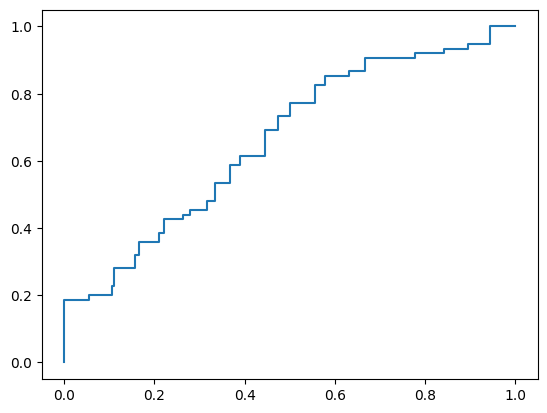

In [194]:

plt.plot(fprs5, tprs5)

In [195]:
integrate_roc_curve(fprs5, tprs5)

0.6610526315789473

In [118]:
fprs = []
tprs = []
for fpr, tpr, th in roc_curves:
    fprs.append(fpr)
    tprs.append(tpr)
fprs = np.hstack(fprs)
tprs = np.hstack(tprs)
sorting = np.argsort(fprs)
fprs = fprs[sorting]
tprs = tprs[sorting]

In [119]:
fprs, tprs

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.05555556,
        0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
        0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.10526316,
        0.10526316, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.15789474, 0.15789474,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.21052632, 0.21052632,
        0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
        0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
        0.26315789, 0.26315789, 0.27777778, 0.27777778, 0.27777778,
        0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
        0.27777778, 0.27777778, 0.31578947, 0.31

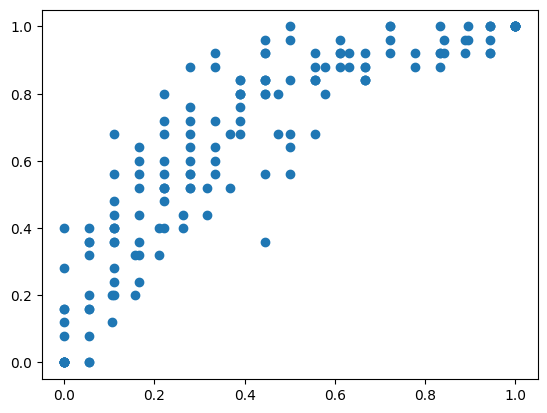

In [120]:
plt.scatter(fprs, tprs)

In [77]:
data.to_csv('raw-aggregated4.csv')

In [78]:
data.head()

,p,n,k,dataset,classifier,classifier_params,best_acc,best_sens,best_spec,best_acc_train,...,spec,auc,acc_train,sens_train,spec_train,auc_train,n_nodes,n_nodes_train,roc,roc_train
0,200,145,8,bupa,SVC,"{'probability': True, 'C': 0.4603054539689608}",0.579744,1.000000,0.000000,0.579711,...,0.649488,0.731784,0.752794,0.774286,0.723160,0.824103,19.75,100.250,"[([0.0, 0.0, 0.10526315789473684, 0.1052631578...","[([0.0, 0.0, 0.007936507936507936, 0.007936507..."
1,145,200,2,bupa,RandomForestClassifier,"{'max_depth': 4, 'random_state': 5}",0.579715,0.000000,1.000000,0.579715,...,0.720000,0.733862,0.924620,0.937785,0.915000,0.977109,72.50,22.000,"[([0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0....","[([0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.05, 0.0..."
2,126,225,8,ionosphere,DecisionTreeClassifier,"{'max_depth': 5, 'random_state': 5}",0.871829,0.785937,0.919643,0.963370,...,0.919643,0.888328,0.967441,0.911589,0.998731,0.970760,4.25,5.125,"[([0.0, 0.0, 1.0], [0.0, 0.8666666666666667, 1...","[([0.0, 0.0, 0.07142857142857142, 0.9744897959..."
3,145,200,2,bupa,SVC,"{'probability': True, 'C': 0.08889747830955769}",0.579715,0.000000,1.000000,0.579715,...,0.615000,0.681413,0.756553,0.765696,0.750000,0.846906,78.50,53.500,"[([0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.05, 0.0...","[([0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.0..."
4,429,1055,8,yeast1,SVC,"{'probability': True, 'C': 0.2553153590001828}",0.710920,0.000000,1.000000,0.710917,...,0.839781,0.789363,0.776762,0.594738,0.850778,0.813447,61.00,385.125,"[([0.0, 0.0, 0.007575757575757576, 0.007575757...","[([0.0, 0.0, 0.0010834236186348862, 0.00108342..."
